### Basic Imports

In [26]:
def train_fn(model, inputs, outputs, loss_fn, optimizer, 
             epochs=100, batch_size=32, verbose=False, 
             model_type='autoencoder', beta=0.0):
    model.train()
    losses = []
    for epoch in range(epochs):
        for i in range(0, len(inputs), batch_size):
            x = inputs[i:i+batch_size]
            y = outputs[i:i+batch_size]

            if model_type == 'autoencoder':
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
            elif model_type == 'vae':
                y_pred, mu, std = model(x)
                loss = loss_fn(y_pred, y, mu, std, beta)[0]
            else:
                raise ValueError("Unsupported model type. Use 'autoencoder' or 'vae'.")

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, loss={loss.item():.4f}")

    return losses

In [27]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import seaborn as sns
import pandas as pd

dist =torch.distributions
import torchsummary

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

from functools import partial

In [28]:
n_epochs = 100

In [29]:
from astra.torch.data import load_mnist


In [30]:
# Create a sine activation class similar to ReLU
class Sine(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.tensor(1.0))
        self.b = nn.Parameter(torch.tensor(0.0))
        
    def forward(self, x):
        return torch.sin(self.w * x + self.b)

In [31]:
# Autoencoder class with 1 hidden layer and hidden dim = z
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size=128, z=2, act = nn.ReLU()):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            act, # Using Sine activation
            nn.Linear(hidden_size, z)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z, hidden_size),
            act,
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()  # Sigmoid activation for reconstruction
        )

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [33]:
dataset = load_mnist()
dataset


MNIST Dataset
length of dataset: 70000
shape of images: torch.Size([28, 28])
len of classes: 10
classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
dtype of images: torch.float32
dtype of labels: torch.int64

In [38]:
# Train over 1000 images
train_idx = torch.arange(1000)
test_idx = torch.arange(1000, 2000)

X = dataset.data[train_idx].to(device)
X_test = dataset.data[test_idx].to(device)
# Add a channel dimension
X = X.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

X = X/255.0
X_test = X_test/255.0


In [39]:
model = Autoencoder(input_size=784, hidden_size=128, z=32,act=Sine()).to(device)

In [40]:
X.shape

torch.Size([1000, 1, 28, 28])

In [41]:
model(X.view(-1, 28*28*1)).shape

torch.Size([1000, 784])

In [42]:
# Get reconstruction
def get_reconstruction(model, X, model_type='MLP'):
    with torch.no_grad():
        model.eval()
        if model_type == 'MLP':
           X = X.view(-1, 28*28*1)
        X_hat = model(X)
        if type(X_hat) == tuple: # for VAE
            X_hat = X_hat[0]
        if model_type == 'MLP':
           X_hat = X_hat.view(-1, 1, 28, 28)
        return X_hat

In [43]:
r = get_reconstruction(model, X)
r.max(), r.min(), r.shape

(tensor(0.5956, device='cuda:0'),
 tensor(0.4148, device='cuda:0'),
 torch.Size([1000, 1, 28, 28]))

In [44]:
nn.MSELoss()(r, X)

tensor(0.2315, device='cuda:0')

In [45]:
# Plot original and reconstructed images
def plot_reconstructions(model, X, n=5, model_type='MLP'):
    X = X[:n]
    X_hat = get_reconstruction(model, X, model_type=model_type)
    # Use torchvision.utils.make_grid to make a grid of images
    X_grid = torch.cat([X, X_hat], dim=0)
    X_grid = torchvision.utils.make_grid(X_grid, nrow=n)
    plt.imshow(X_grid.cpu().permute(1, 2, 0).numpy())
    plt.axis('off')

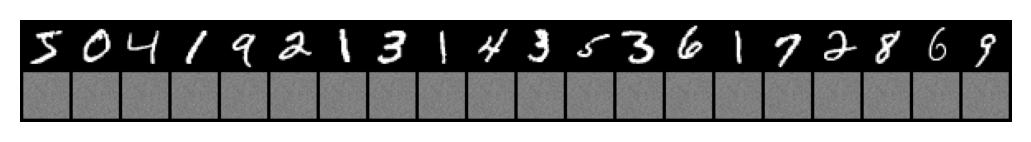

In [46]:
plot_reconstructions(model, X, 20)

In [47]:
setattr(model, 'device', device)
l = train_fn(model=model, inputs=X.view(-1, 28*28),
                                     outputs=X.view(-1, 28*28),
                                     loss_fn=nn.MSELoss(),
                                     optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
                                     epochs=1000,
                                        batch_size=500,
                                        verbose=False)


In [48]:
r = get_reconstruction(model, X)

In [49]:
r.min(), r.max()

(tensor(4.3413e-08, device='cuda:0'), tensor(1.0000, device='cuda:0'))

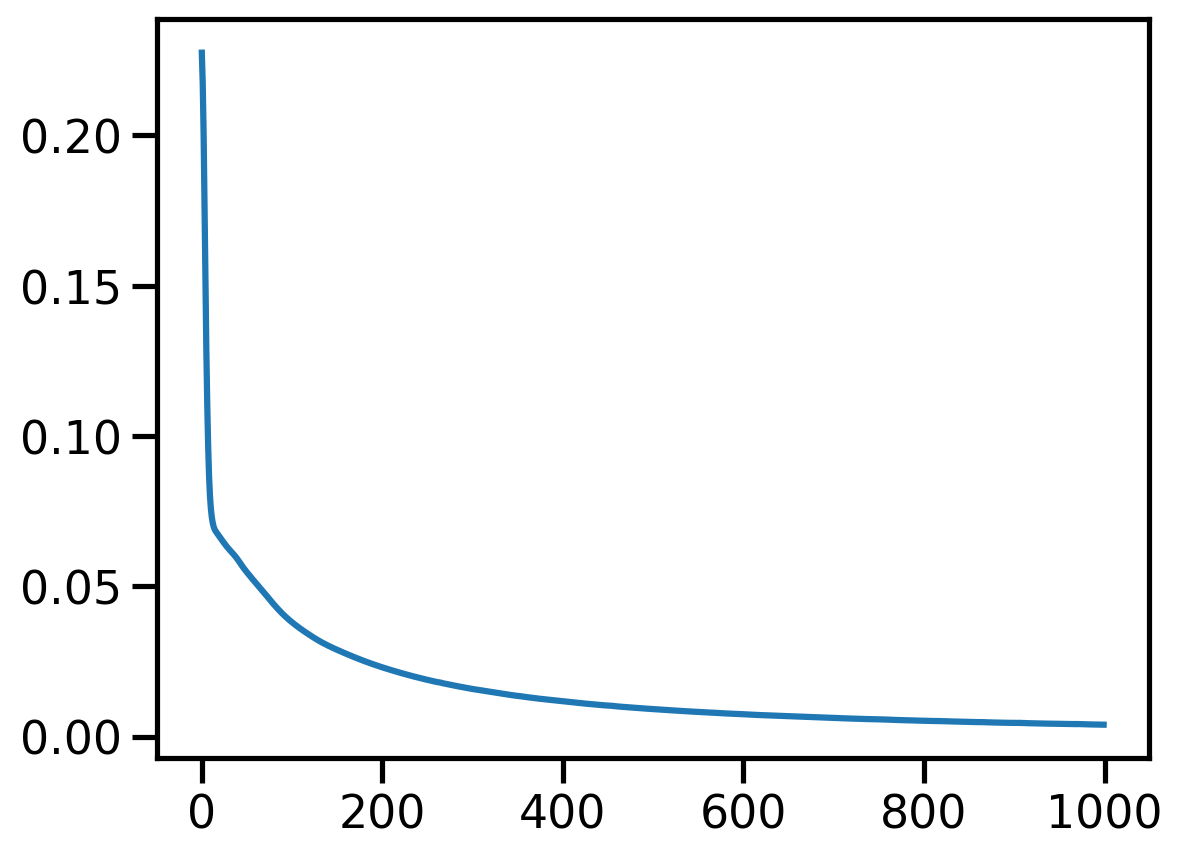

In [50]:
_ = plt.plot(l)

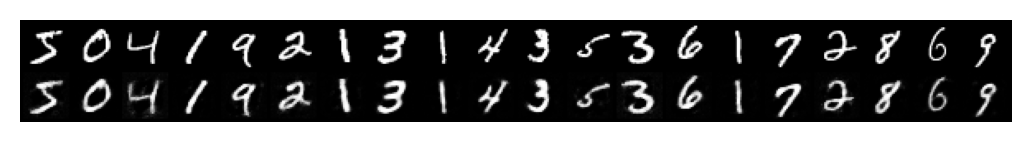

In [51]:
plot_reconstructions(model, X, 20)

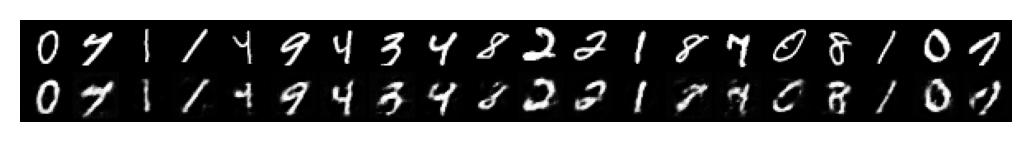

In [52]:
plot_reconstructions(model, X_test, 20)

In [53]:
import torch.nn as nn

class ConvAutoEncoderMNIST(nn.Module):
    def __init__(self, latent_dim=2, act=nn.ReLU()):
        super(ConvAutoEncoderMNIST, self).__init__()
        self.latent_dim = latent_dim

        # Encoder layers with further reduced filters
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),  # 1X28X28 -> 4X28X28
            act,
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=2, padding=1),  # 4X28X28 -> 8X14X14
            act,
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),  # 8X14X14 -> 16X7X7
            act,
            nn.Flatten(),  # 16X7X7 -> 784
            nn.Linear(784, self.latent_dim)
        )

        # Decoder layers with further reduced filters
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 784),  # 784 -> 16X7X7
            nn.Unflatten(1, (16, 7, 7)),  # 784 -> 16X7X7
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16X7X7 -> 8X14X14
            act,
            nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8X14X14 -> 4X28X28
            act,
            nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=3, padding=1),  # 4X28X28 -> 1X28X28
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_prime = self.decoder(z)
        return x_prime


In [54]:
m = ConvAutoEncoderMNIST(latent_dim=32, act=Sine()).to(device)
torchsummary.summary(m, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
              Sine-2            [-1, 4, 28, 28]               0
              Sine-3            [-1, 4, 28, 28]               0
            Conv2d-4            [-1, 8, 14, 14]             296
              Sine-5            [-1, 8, 14, 14]               0
              Sine-6            [-1, 8, 14, 14]               0
            Conv2d-7             [-1, 16, 7, 7]           1,168
              Sine-8             [-1, 16, 7, 7]               0
              Sine-9             [-1, 16, 7, 7]               0
          Flatten-10                  [-1, 784]               0
           Linear-11                   [-1, 32]          25,120
           Linear-12                  [-1, 784]          25,872
        Unflatten-13             [-1, 16, 7, 7]               0
  ConvTranspose2d-14            [-1, 8,

In [55]:
m(X).shape

torch.Size([1000, 1, 28, 28])

In [56]:
latent_dim_ranges = [2, 4, 8, 16, 32, 64, 128]

In [58]:
caes = {}
for latent_dim in latent_dim_ranges[:]:
    caes[latent_dim] = ConvAutoEncoderMNIST(latent_dim=latent_dim, act=Sine()).to(device)
    setattr(caes[latent_dim], 'device', device)

In [59]:
torchsummary.summary(caes[2], (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
              Sine-2            [-1, 4, 28, 28]               0
              Sine-3            [-1, 4, 28, 28]               0
            Conv2d-4            [-1, 8, 14, 14]             296
              Sine-5            [-1, 8, 14, 14]               0
              Sine-6            [-1, 8, 14, 14]               0
            Conv2d-7             [-1, 16, 7, 7]           1,168
              Sine-8             [-1, 16, 7, 7]               0
              Sine-9             [-1, 16, 7, 7]               0
          Flatten-10                  [-1, 784]               0
           Linear-11                    [-1, 2]           1,570
           Linear-12                  [-1, 784]           2,352
        Unflatten-13             [-1, 16, 7, 7]               0
  ConvTranspose2d-14            [-1, 8,

In [60]:
torchsummary.summary(caes[128], (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
              Sine-2            [-1, 4, 28, 28]               0
              Sine-3            [-1, 4, 28, 28]               0
            Conv2d-4            [-1, 8, 14, 14]             296
              Sine-5            [-1, 8, 14, 14]               0
              Sine-6            [-1, 8, 14, 14]               0
            Conv2d-7             [-1, 16, 7, 7]           1,168
              Sine-8             [-1, 16, 7, 7]               0
              Sine-9             [-1, 16, 7, 7]               0
          Flatten-10                  [-1, 784]               0
           Linear-11                  [-1, 128]         100,480
           Linear-12                  [-1, 784]         101,136
        Unflatten-13             [-1, 16, 7, 7]               0
  ConvTranspose2d-14            [-1, 8,

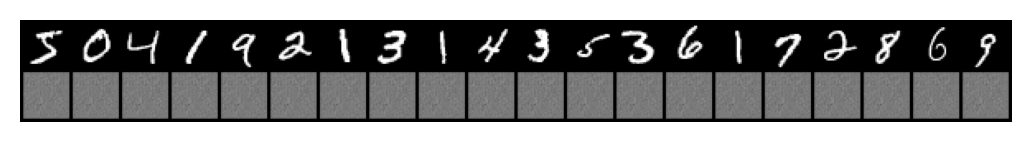

In [31]:
plot_reconstructions(caes[2], X, 20, model_type='CNN')

In [61]:
loss = {}
for latent_dim in latent_dim_ranges[:]:
    print(f"Training for latent_dim = {latent_dim}")
    loss[latent_dim] = train_fn(model=caes[latent_dim],
                                                        inputs=X,
                                                        outputs=X,
                                                        loss_fn=nn.MSELoss(),
                                                        optimizer=torch.optim.Adam(caes[latent_dim].parameters(), lr=1e-3),
                                                        epochs=1000,
                                                        batch_size=500,
                                                        verbose=False)


Training for latent_dim = 2
Training for latent_dim = 4
Training for latent_dim = 8
Training for latent_dim = 16
Training for latent_dim = 32
Training for latent_dim = 64
Training for latent_dim = 128


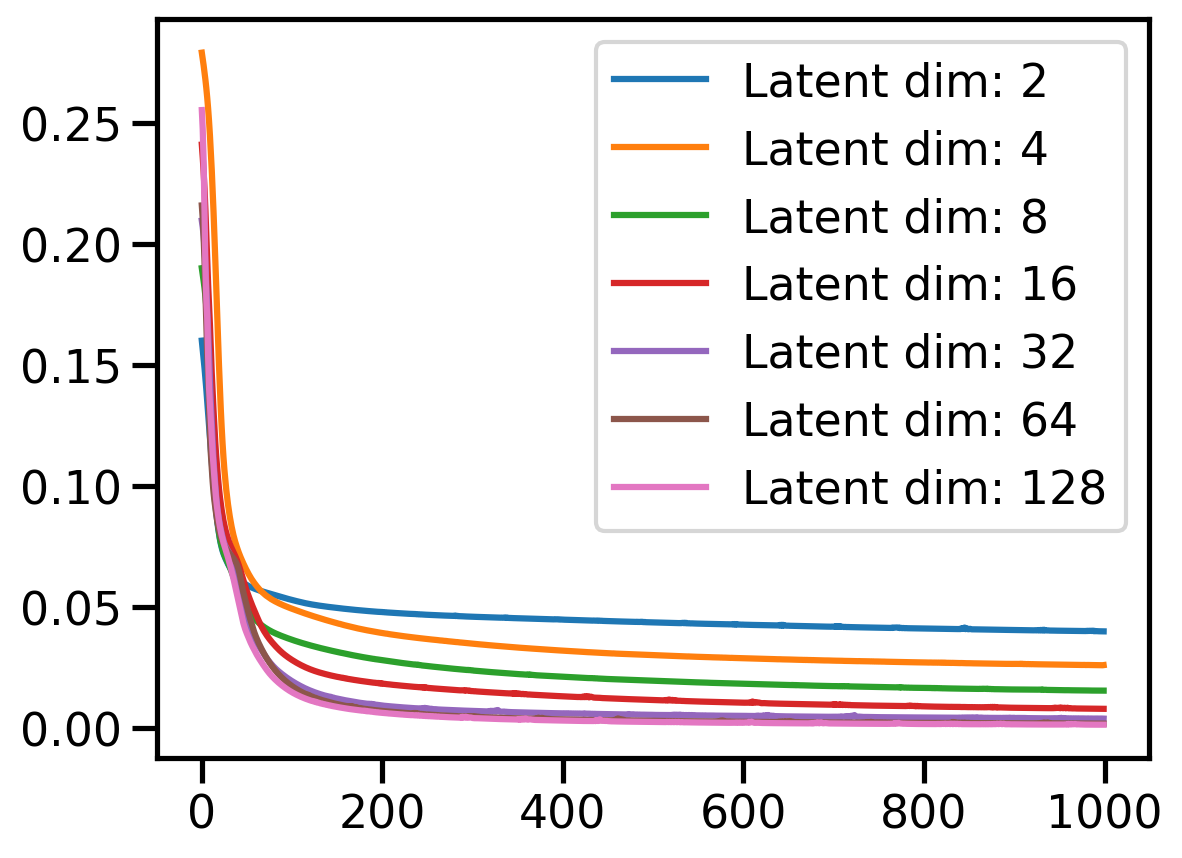

In [62]:
for latent_dim in latent_dim_ranges[:]:
    plt.plot(loss[latent_dim], label=f'Latent dim: {latent_dim}')
plt.legend()

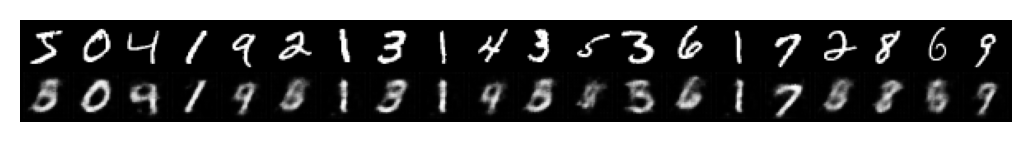

In [63]:
# Plot reconstructions
plot_reconstructions(caes[2], X, 20, model_type='CNN')

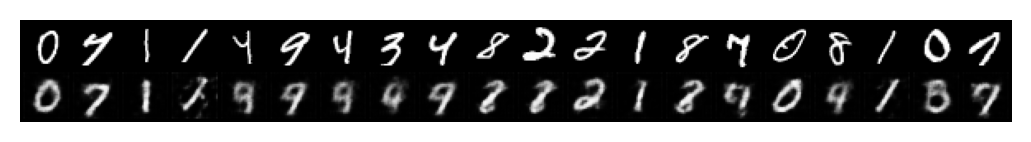

In [64]:
plot_reconstructions(caes[2], X_test, 20, model_type='CNN')

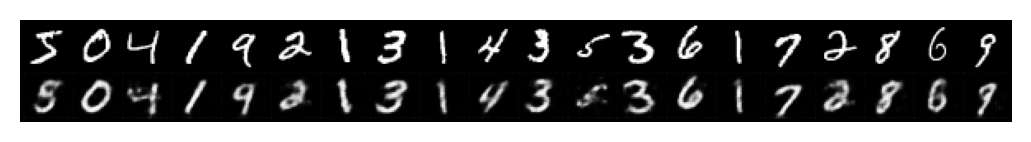

In [65]:
plot_reconstructions(caes[4], X, 20, 'CNN')

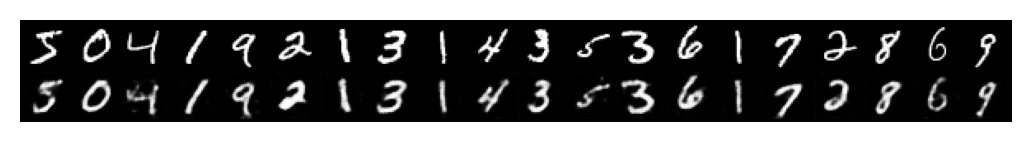

In [66]:
plot_reconstructions(caes[8], X, 20, 'CNN')

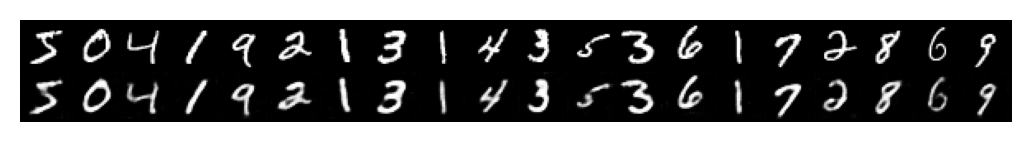

In [67]:
plot_reconstructions(caes[16], X, 20, 'CNN')

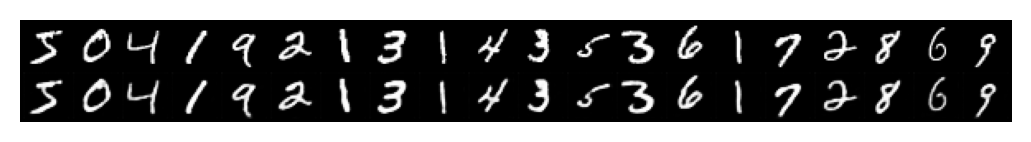

In [68]:
plot_reconstructions(caes[128], X, 20, 'CNN')

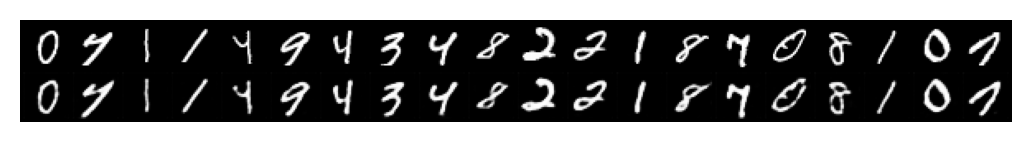

In [69]:
plot_reconstructions(caes[128], X_test, 20, 'CNN')

In [39]:
# Give a random input to the model and get the output
def get_random_output(model, n=5, latent_dim=2):
    with torch.no_grad():
        model.eval()
        z = torch.randn(n, latent_dim).to(device)
        X_hat = model.decoder(z)
        return X_hat

# Plot random outputs
def plot_random_outputs(model, n=5, latent_dim=2):
    X_hat = get_random_output(model, n, latent_dim)
    X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)
    plt.imshow(X_grid.cpu().permute(1, 2, 0).numpy())
    plt.axis('off')

/tmp/ipykernel_1330344/4035786813.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)


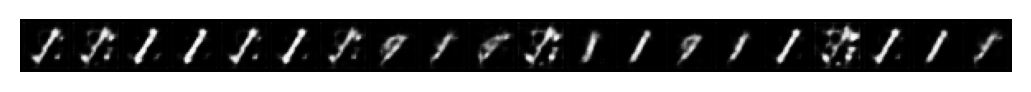

In [40]:
plot_random_outputs(caes[2], n=20)

/tmp/ipykernel_1330344/4035786813.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)


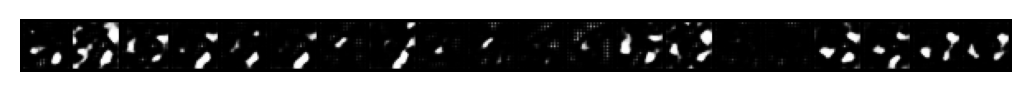

In [41]:
plot_random_outputs(caes[8], n=20, latent_dim=8)

/tmp/ipykernel_1330344/4035786813.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)


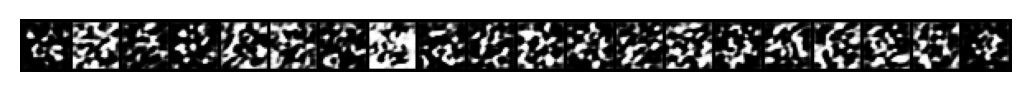

In [42]:
plot_random_outputs(caes[128], n=20, latent_dim=128)

In [43]:
# Interpolate between two points in latent space
def interpolate(model, z1, z2, n=5):
    with torch.no_grad():
        model.eval()
        z = torch.zeros(n, z1.shape[1]).to(device)
        for i in range(n):
            z[i] = z1 + (z2 - z1) * (i / (n - 1))
        X_hat = model.decoder(z)
        return X_hat

# Plot interpolation
def plot_interpolation(model, img1, img2, n=5):
    z1 = model.encoder(X[img1].unsqueeze(0))
    z2 = model.encoder(X[img2].unsqueeze(0))
    X_hat = interpolate(model, z1, z2, n)
    X_grid = torchvision.utils.make_grid(X_hat, nrow=n)
    plt.imshow(X_grid.cpu().permute(1, 2, 0).numpy())
    plt.axis('off')

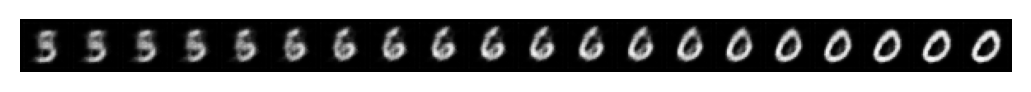

In [44]:
plot_interpolation(caes[2], 0, 1, 20)

In [45]:
# Interactive widget to plot interpolation
from ipywidgets import interact, IntSlider

def plot_interpolation_widget(img1, img2, latent_dim=2, n=20):
    plot_interpolation(caes[latent_dim], img1, img2, n)

interact(plot_interpolation_widget, img1=IntSlider(0, 0, 1000), 
         img2=IntSlider(1, 0, 1000), 
         latent_dim=latent_dim_ranges,
         n=IntSlider(20, 5, 50))

interactive(children=(IntSlider(value=0, description='img1', max=1000), IntSlider(value=1, description='img2',…

<function __main__.plot_interpolation_widget(img1, img2, latent_dim=2, n=20)>

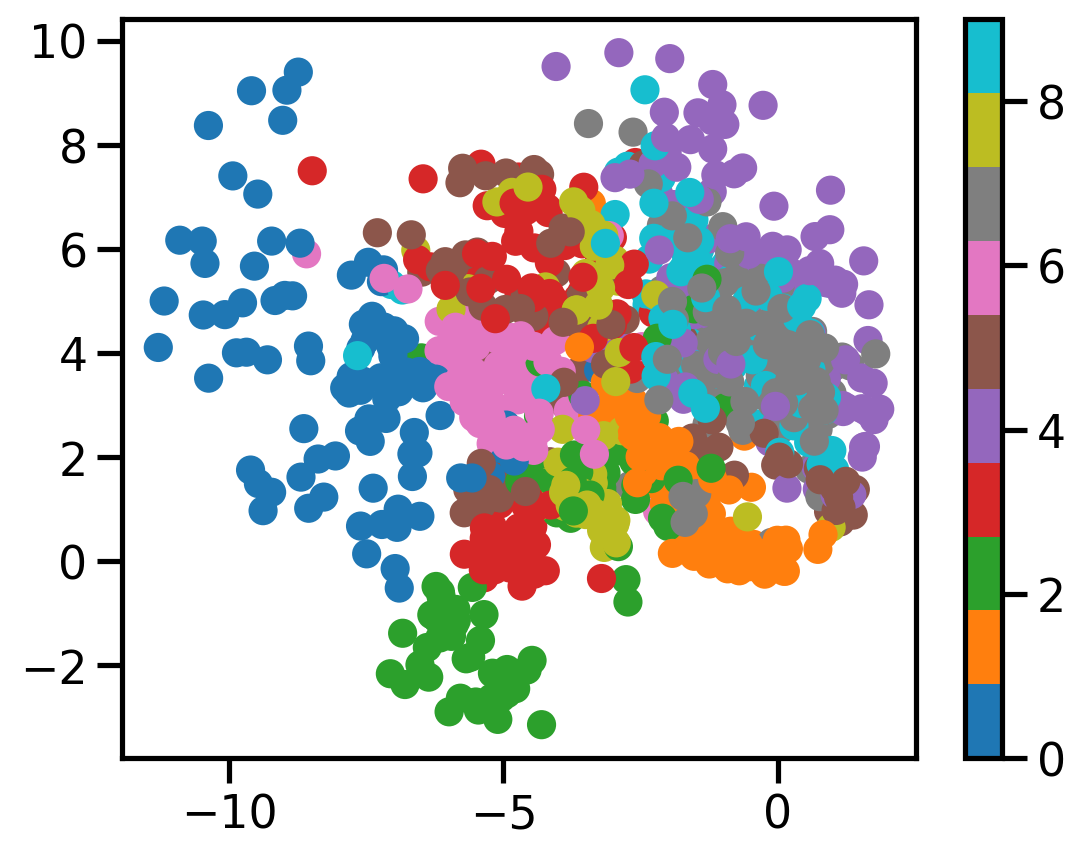

In [46]:
# plot scatter plot on 2d space for latent dim = 2 for all images
def plot_scatter(model, X, y, n=1000, latent_dim=2):
    with torch.no_grad():
        model.eval()
        z = model.encoder(X[:n].view(-1, 1, 28, 28)).cpu().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y[:n], cmap='tab10')
        plt.colorbar()

plot_scatter(caes[2], X, dataset.targets)

In [53]:
def distance_between_representation(model, img1_id, img2_id):
    with torch.no_grad():
        model.eval()
        z1 = model.encoder(X[img1_id].unsqueeze(0))
        z2 = model.encoder(X[img2_id].unsqueeze(0))
        return torch.dist(z1, z2).item()
    

In [57]:
def find_all_occurences_digit(digit):
    return torch.where(dataset.targets == digit)[0]

In [110]:
all_0s = find_all_occurences_digit(0)
all_1s = find_all_occurences_digit(1)

In [60]:
# Find distance between two 0s
distance_between_representation(caes[2], all_0s[0], all_0s[1])

0.2112869769334793

In [61]:
distance_between_representation(caes[4], all_0s[0], all_0s[1])

0.9414359331130981

In [62]:
distance_between_representation(caes[128], all_0s[0], all_0s[1])

7.251440525054932

In [95]:
def plot_latent_space_2d(model, x_min=-2.0, x_max=2.0, y_min=-2.0, y_max=2.0, n=20):
    
    
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, n), torch.linspace(y_min, y_max, n))
    z_grid = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)
    z_grid = z_grid.to(device)
    
    # Get the output from the decoder
    X_hat = model.decoder(z_grid)
    X_hat = X_hat.view(n, n, 28, 28)
    X_hat = X_hat.cpu().detach().numpy()
    
    # Plot the output
    plt.figure(figsize=(8, 8))
    import numpy as np
    plt.imshow(np.block(list(map(list, X_hat))), cmap='gray')
    plt.axis('off')


In [96]:
def find_latent_space_lims(model):
    with torch.no_grad():
        model.eval()
        zs = model.encoder(X.view(-1, 1, 28, 28)).cpu().numpy()

    # Find the min and max of the latent space
    x_min = zs[:, 0].min() - 0.5
    x_max = zs[:, 0].max() + 0.5

    y_min = zs[:, 1].min() - 0.5
    y_max = zs[:, 1].max() + 0.5
    return x_min, x_max, y_min, y_max

In [97]:
def plot_latent_space_auto_lims(model, n=20):
    x_min, x_max, y_min, y_max = find_latent_space_lims(model)

    plot_latent_space_2d(model, x_min, x_max, y_min, y_max, n)


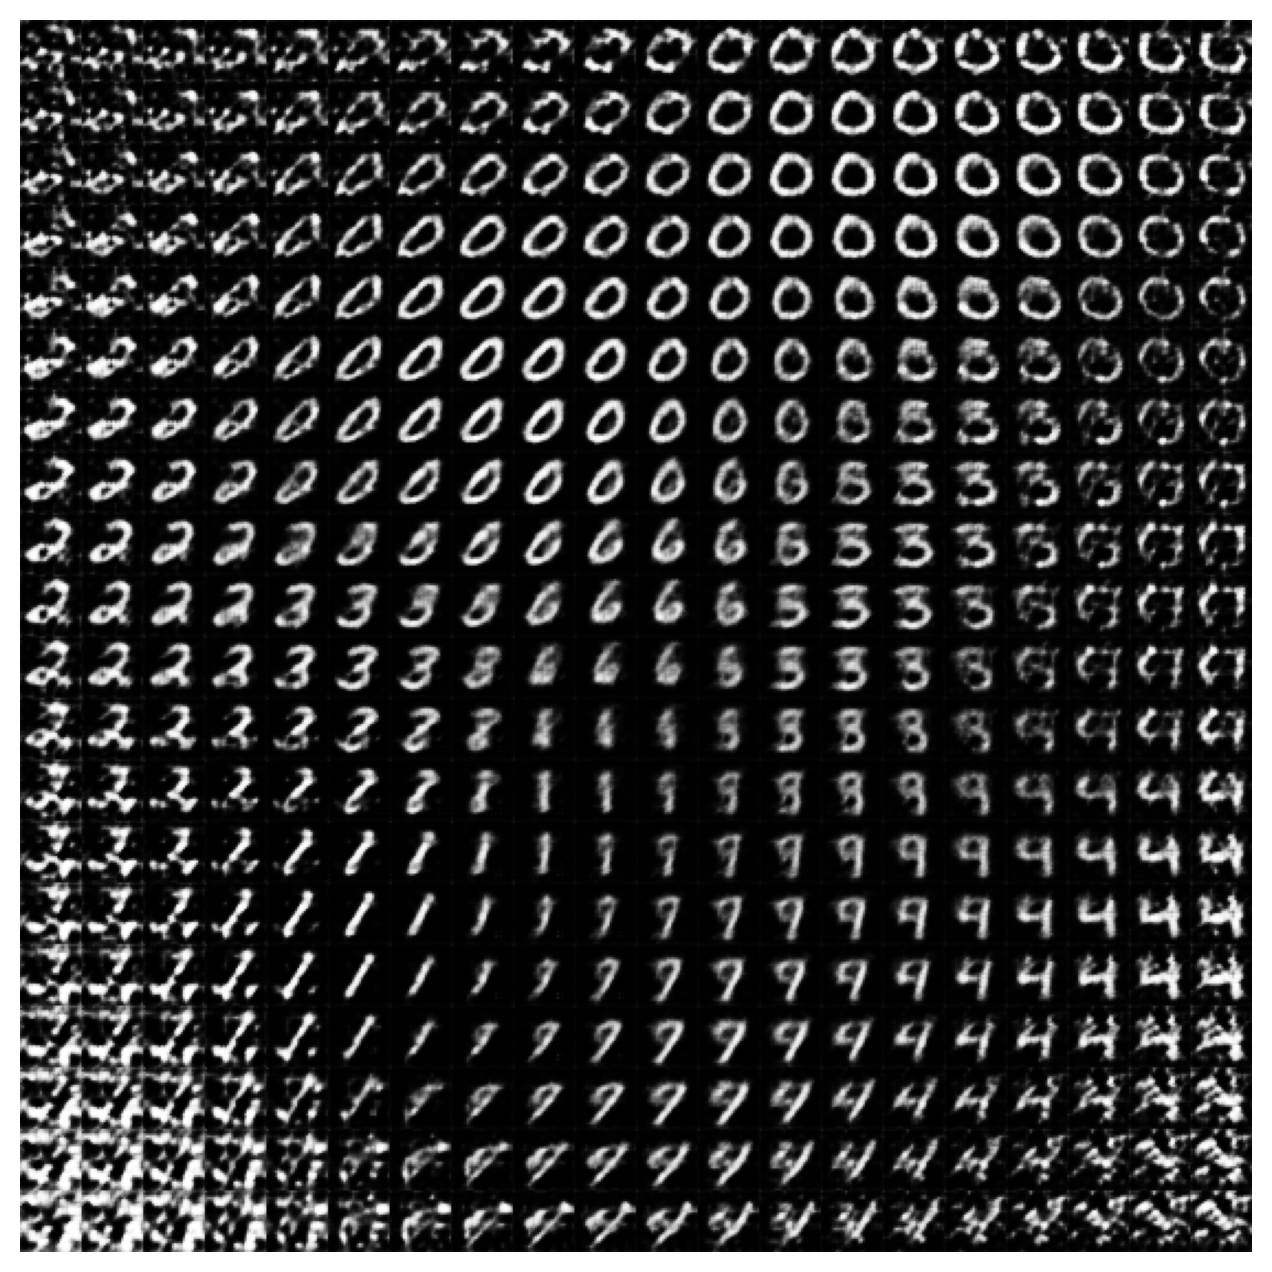

In [98]:
plot_latent_space_auto_lims(caes[2])

In [67]:
class ConvVAEMNIST(nn.Module):
    def __init__(self, latent_dim=2, act=nn.ReLU()):
        super(ConvVAEMNIST, self).__init__()
        self.latent_dim = latent_dim

        # Encoder layers with further reduced filters
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),  # 1X28X28 -> 4X28X28
            act,
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=2, padding=1),  # 4X28X28 -> 8X14X14
            act,
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),  # 8X14X14 -> 16X7X7
            act,
            nn.Flatten(),  # 16X7X7 -> 784
            nn.Linear(784, self.latent_dim*2)
        )

        # Decoder layers with further reduced filters
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 784),  # 784 -> 16X7X7
            nn.Unflatten(1, (16, 7, 7)),  # 784 -> 16X7X7
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16X7X7 -> 8X14X14
            act,
            nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8X14X14 -> 4X28X28
            act,
            nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=3, padding=1),  # 4X28X28 -> 1X28X28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        # Chunk to get mu and logvar
        mu, logvar = torch.chunk(x, 2, dim=1)
        std = torch.exp(0.5 * logvar)
        eps = torch.distributions.normal.Normal(0, 1).sample(std.shape).to(device)
        z = mu + eps * std
        x = self.decoder(z)
        return x, mu, logvar


In [68]:
def VAE_loss(x, x_hat, mu, log_var, beta=1):
    # Reconstruction loss
    recon_loss = nn.MSELoss()(x_hat, x)
    
    std = torch.exp(0.5 * log_var)
    prior = torch.distributions.normal.Normal(0, 1)
    post = torch.distributions.normal.Normal(mu, std)
    kl_loss = torch.distributions.kl.kl_divergence(post, prior).mean()

    return recon_loss + beta * kl_loss, recon_loss, kl_loss

In [69]:
# Forwards pass of untrained model
m = ConvVAEMNIST(latent_dim=32, act=Sine()).to(device)
X_hat, mu, std = m(X)

In [327]:
X.shape, X_hat.shape, mu.shape, std.shape

(torch.Size([1000, 1, 28, 28]),
 torch.Size([1000, 1, 28, 28]),
 torch.Size([1000, 32]),
 torch.Size([1000, 32]))

In [328]:
VAE_loss(X, X_hat, mu, std, beta=1)

(tensor(0.2179, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2157, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0022, device='cuda:0', grad_fn=<MeanBackward0>))

In [72]:
loss_dim_betas = {}
c_vaes = {}
latent_dim_subset = [2, 16, 256]
betas = [0.0, 0.001, 0.01, 0.1, 0.5, 1.0]

for latent_dim in latent_dim_subset:
    print(f"Training for latent_dim = {latent_dim}")
    c_vaes[latent_dim] = {}
    loss_dim_betas[latent_dim] = {}
    for beta in betas:
        print(f"Training for beta = {beta}")
        c_vaes[latent_dim][beta] = ConvVAEMNIST(latent_dim=latent_dim, act=Sine()).to(device)
        setattr(c_vaes[latent_dim][beta], 'device', device)
        loss_dim_betas[latent_dim][beta] = train_fn(model=c_vaes[latent_dim][beta],
                                                        inputs=X,
                                                        outputs=X,
                                                        loss_fn=VAE_loss,
                                                        optimizer=torch.optim.Adam(c_vaes[latent_dim][beta].parameters(), lr=1e-3),
                                                        epochs=1000,
                                                        batch_size=500,
                                                        verbose=False,
                                                        model_type='vae',
                                                        beta=beta)
        
    

Training for latent_dim = 2
Training for beta = 0.0
Training for beta = 0.001
Training for beta = 0.01
Training for beta = 0.1
Training for beta = 0.5
Training for beta = 1.0
Training for latent_dim = 16
Training for beta = 0.0
Training for beta = 0.001
Training for beta = 0.01
Training for beta = 0.1
Training for beta = 0.5
Training for beta = 1.0
Training for latent_dim = 256
Training for beta = 0.0
Training for beta = 0.001
Training for beta = 0.01
Training for beta = 0.1
Training for beta = 0.5
Training for beta = 1.0


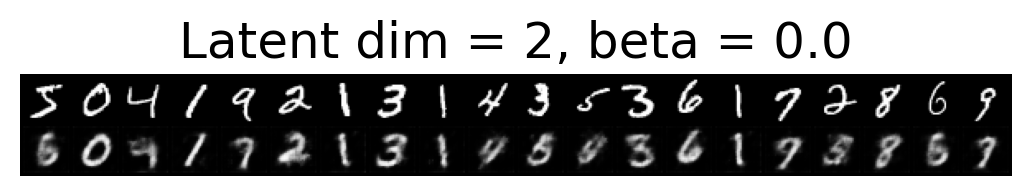

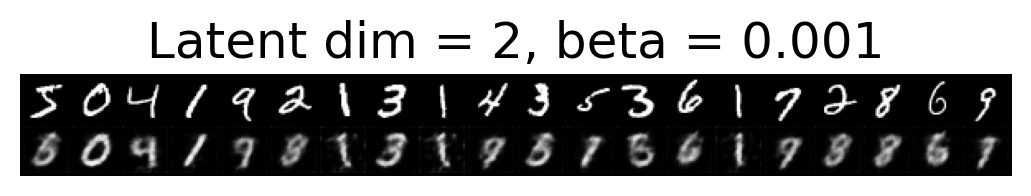

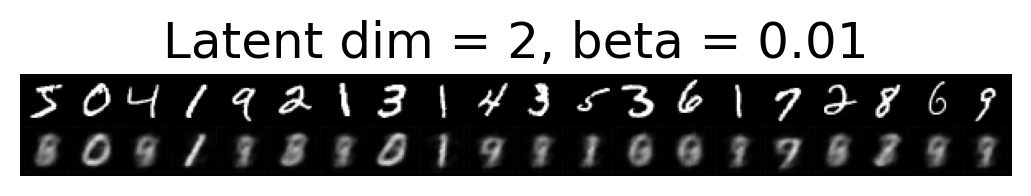

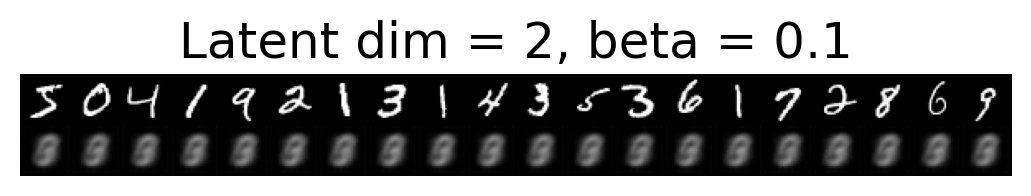

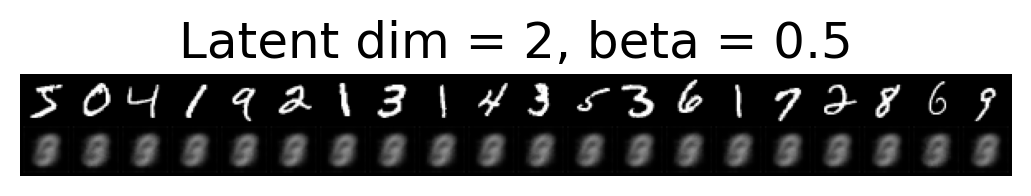

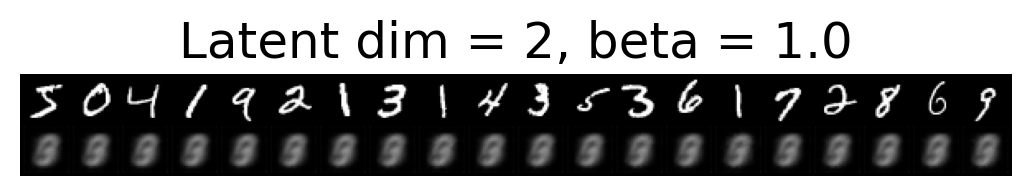

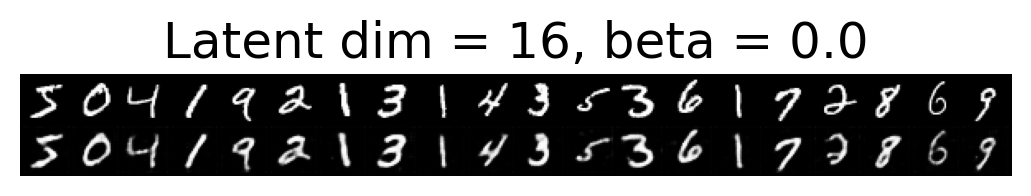

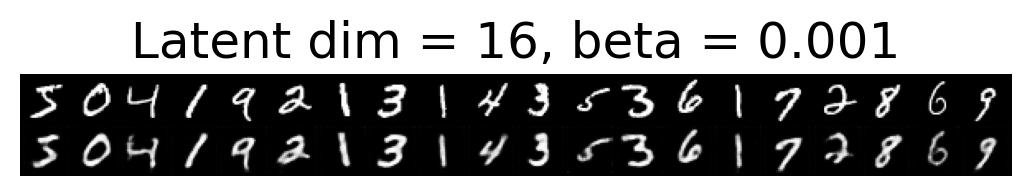

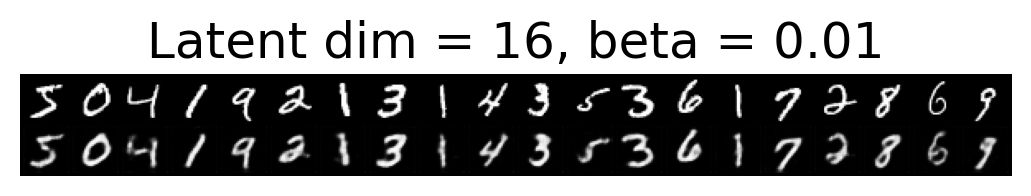

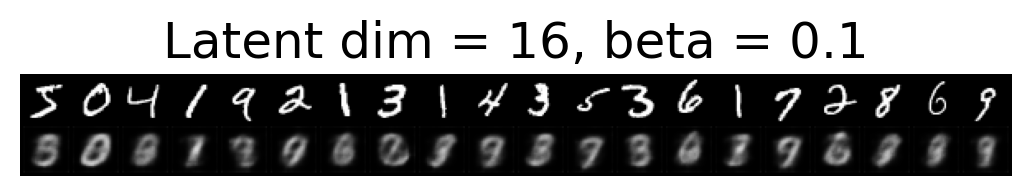

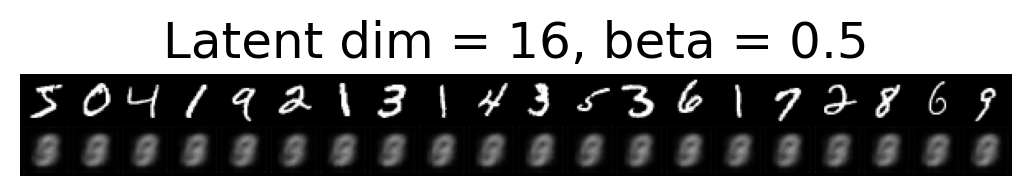

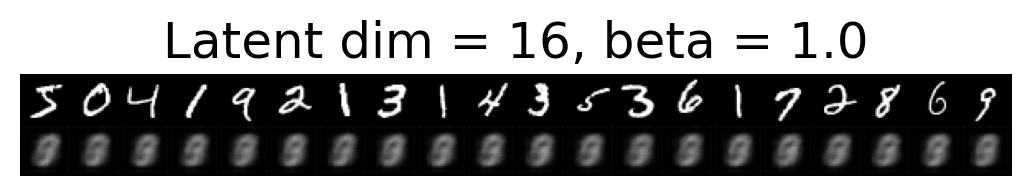

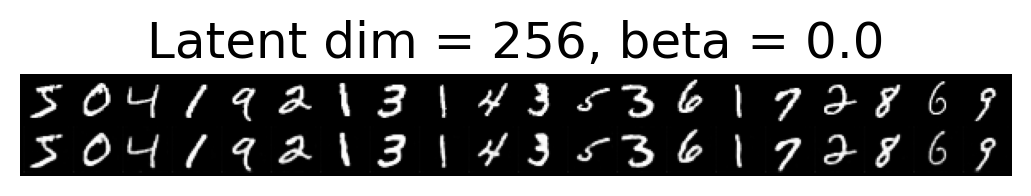

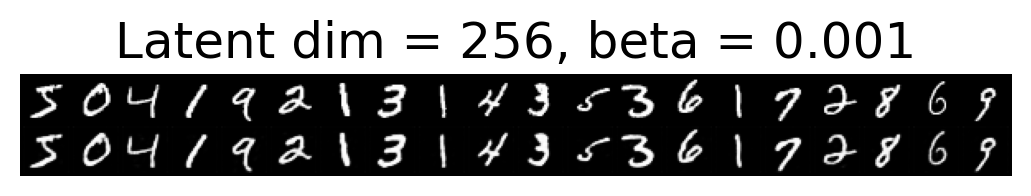

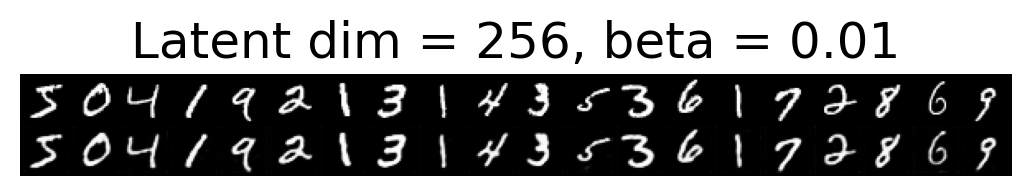

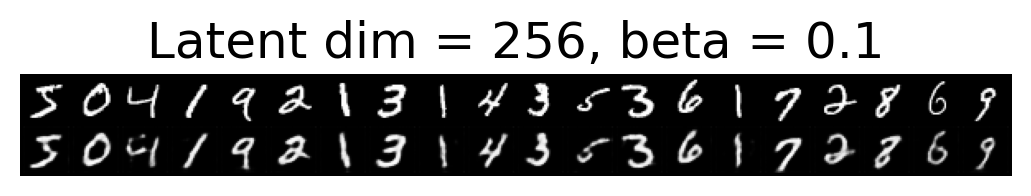

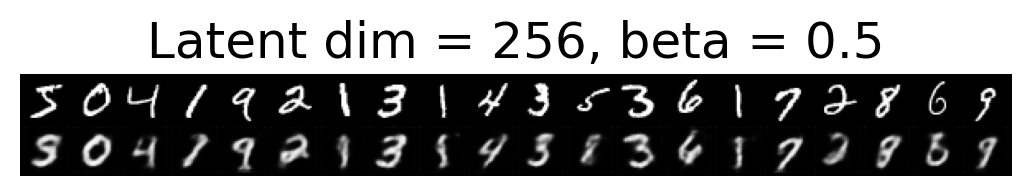

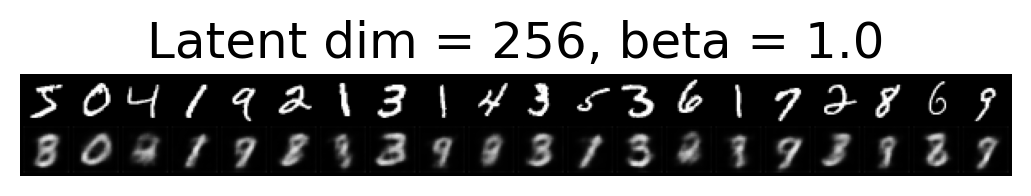

In [106]:
# Plot reconstructions
for latent_dim in latent_dim_subset:
    for beta in betas:
        plt.figure()
        plot_reconstructions(c_vaes[latent_dim][beta], X, 20, model_type='CNN')
        plt.title(f"Latent dim = {latent_dim}, beta = {beta}")


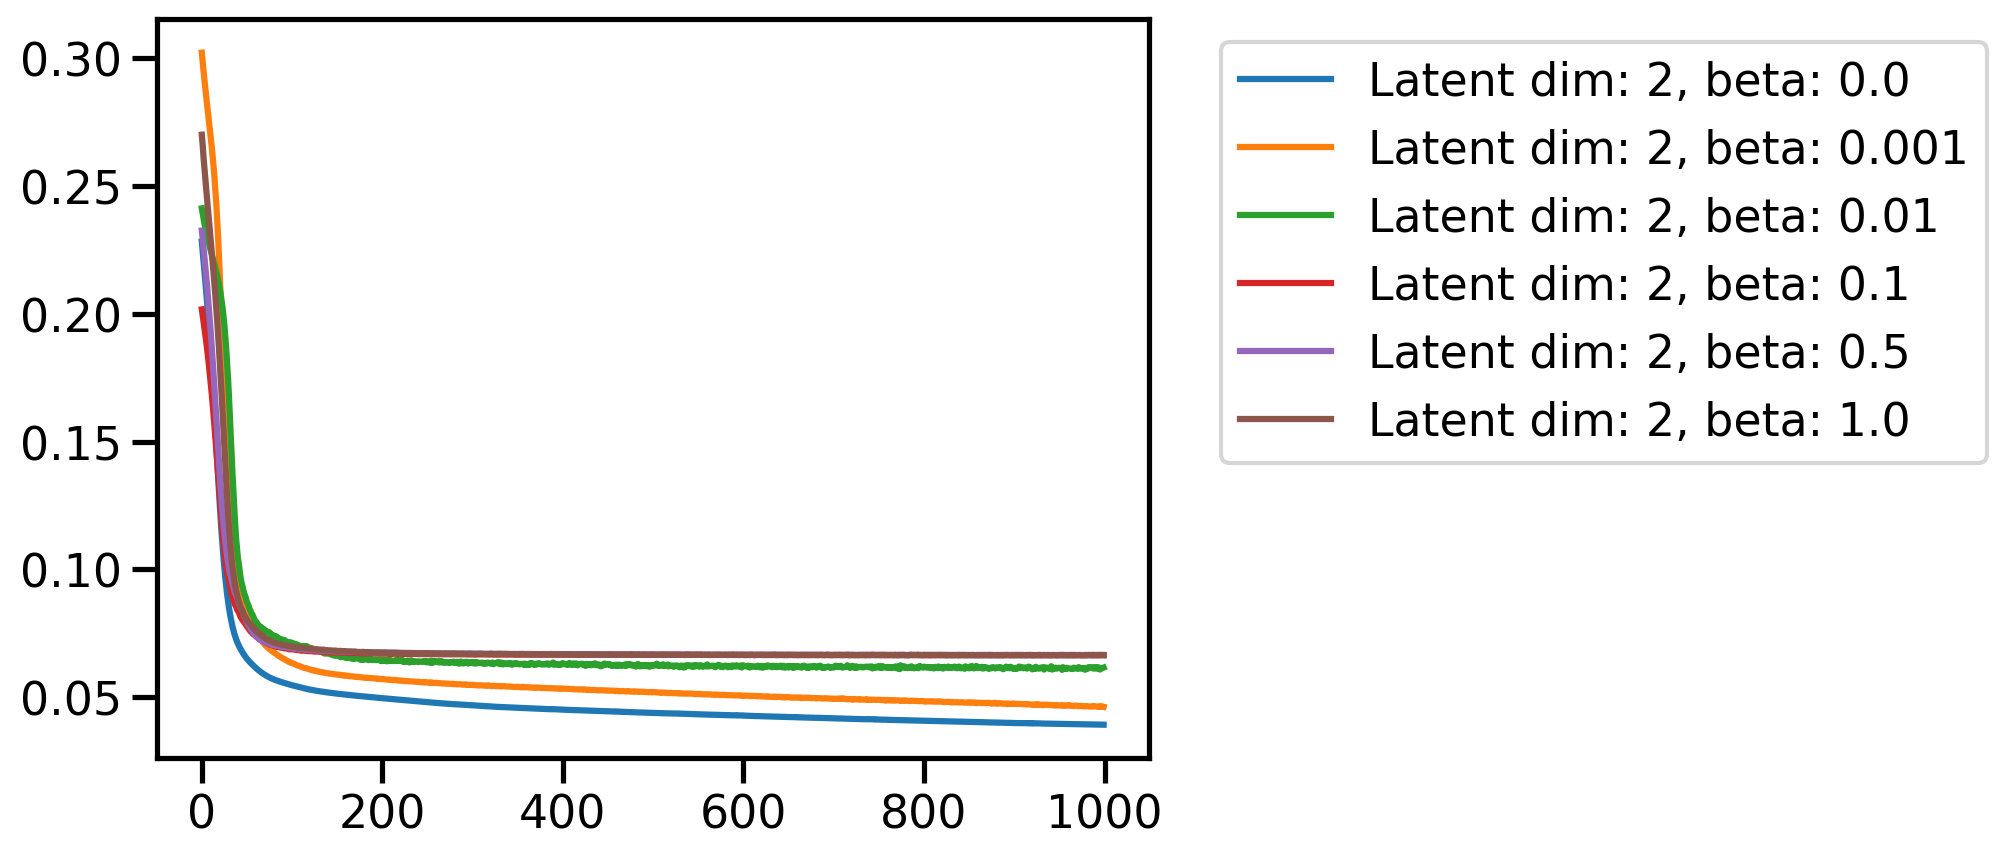

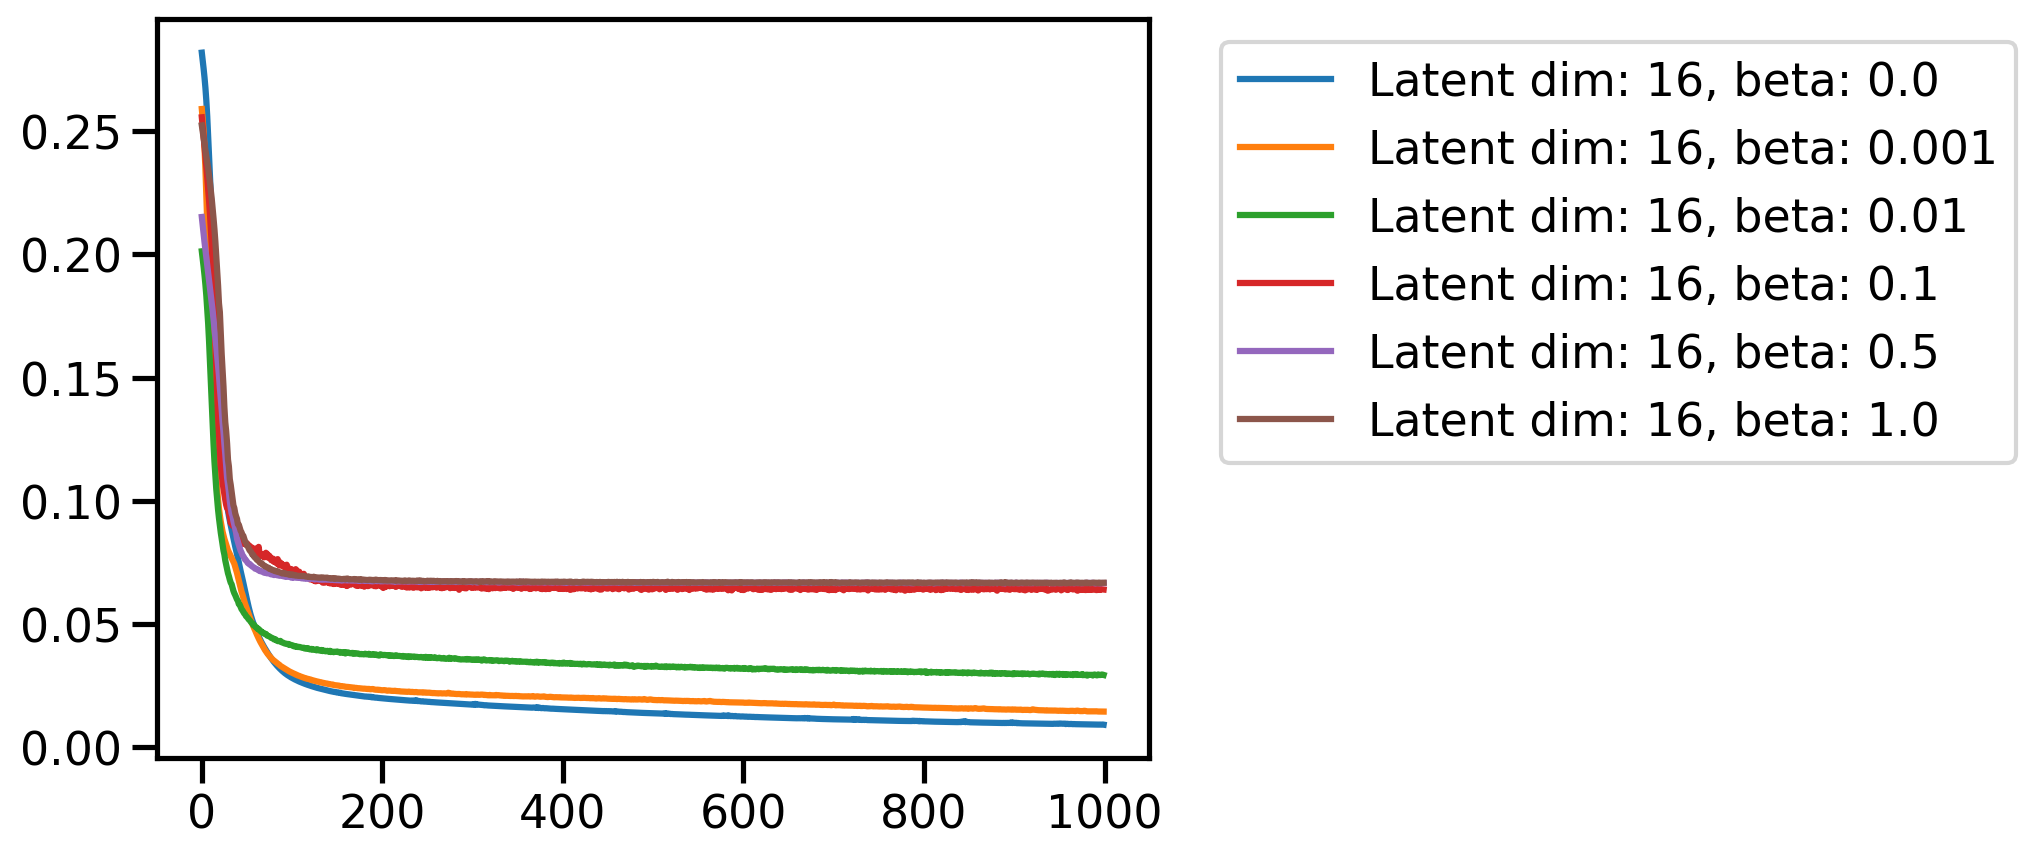

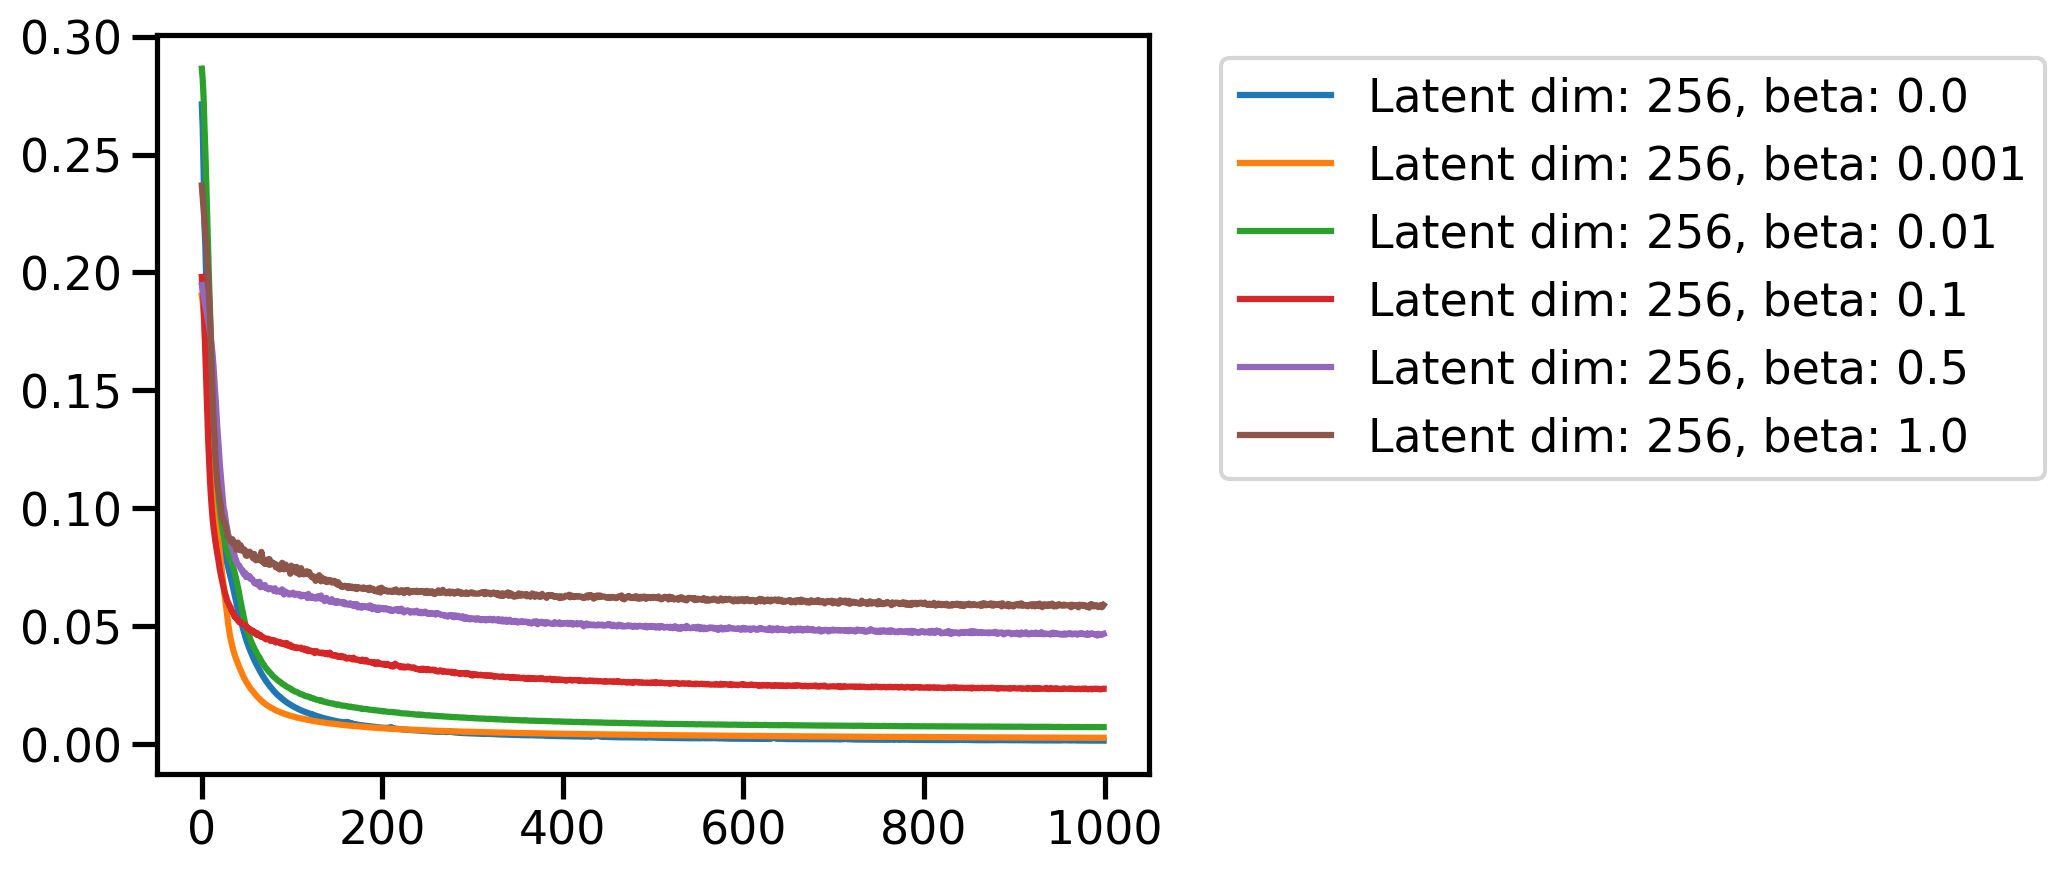

In [76]:
for latent_dim in latent_dim_subset:
    plt.figure()
    for beta in betas:
        plt.plot(loss_dim_betas[latent_dim][beta], label=f'Latent dim: {latent_dim}, beta: {beta}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

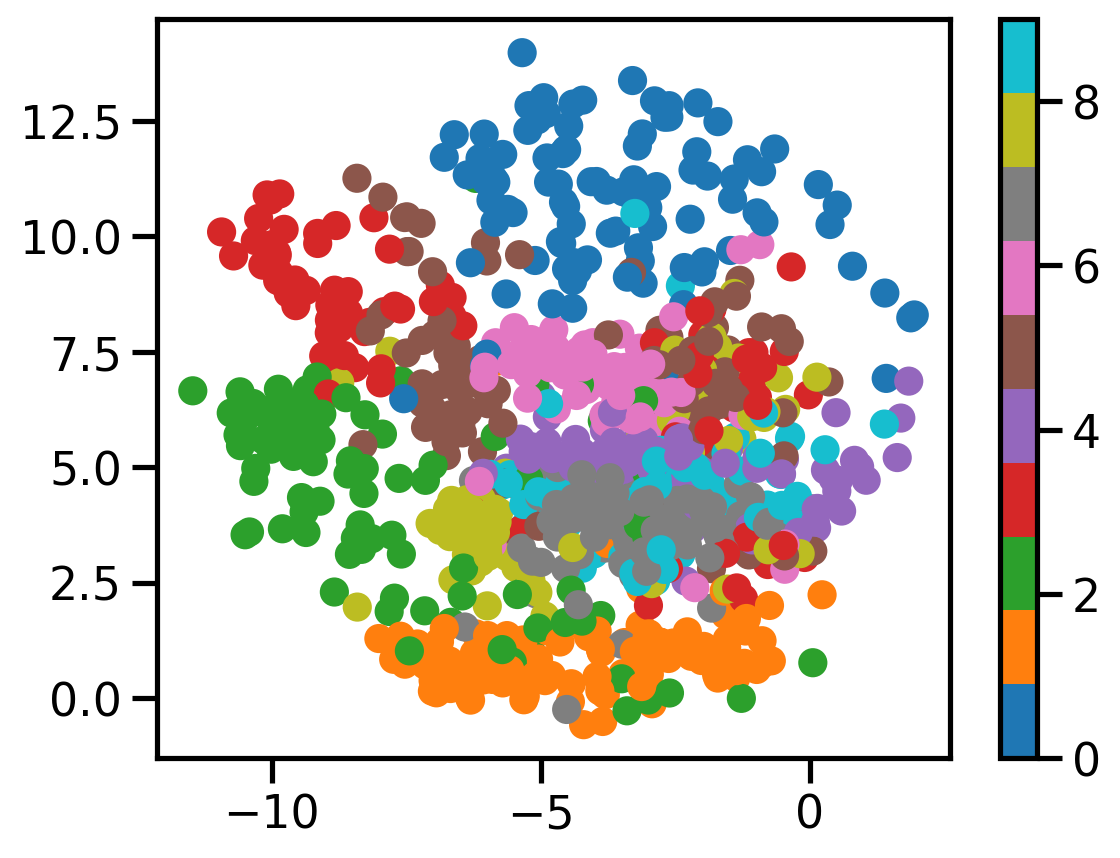

In [79]:
# Plot scatter
plot_scatter(c_vaes[2][0.0], X, dataset.targets)

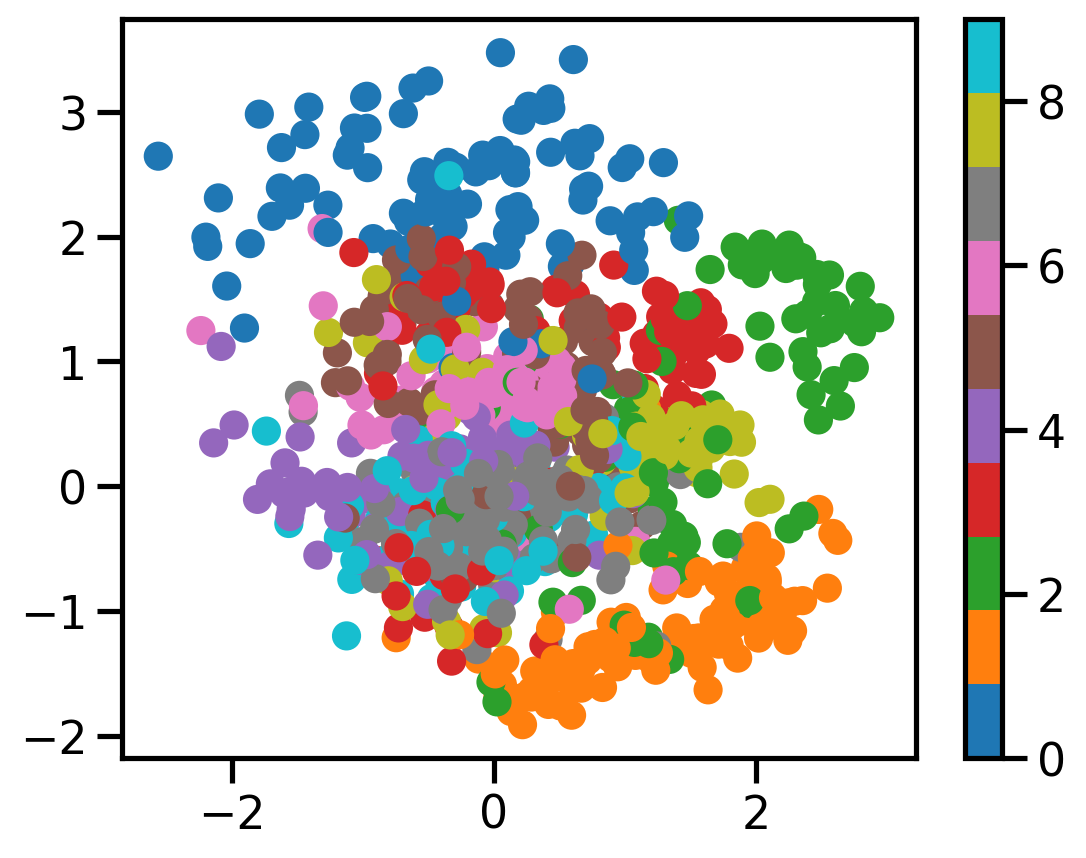

In [81]:
plot_scatter(c_vaes[2][0.001], X, dataset.targets)

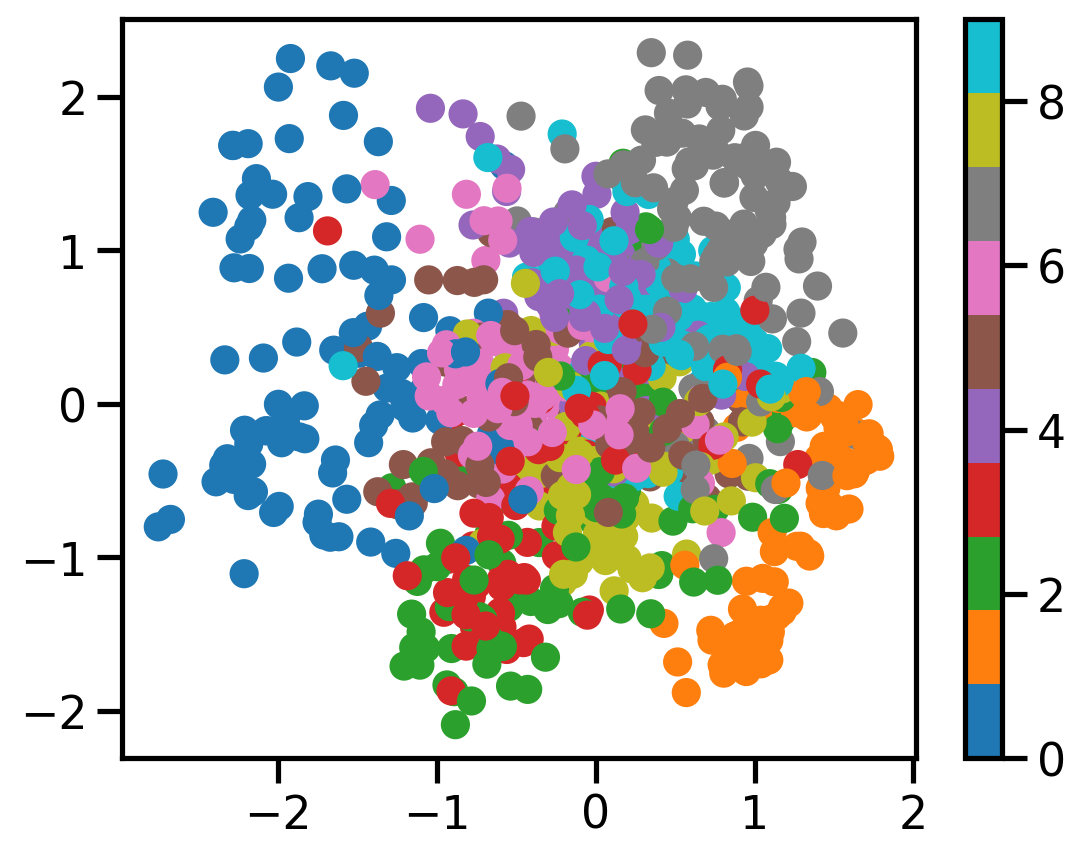

In [82]:
plot_scatter(c_vaes[2][0.01], X, dataset.targets)

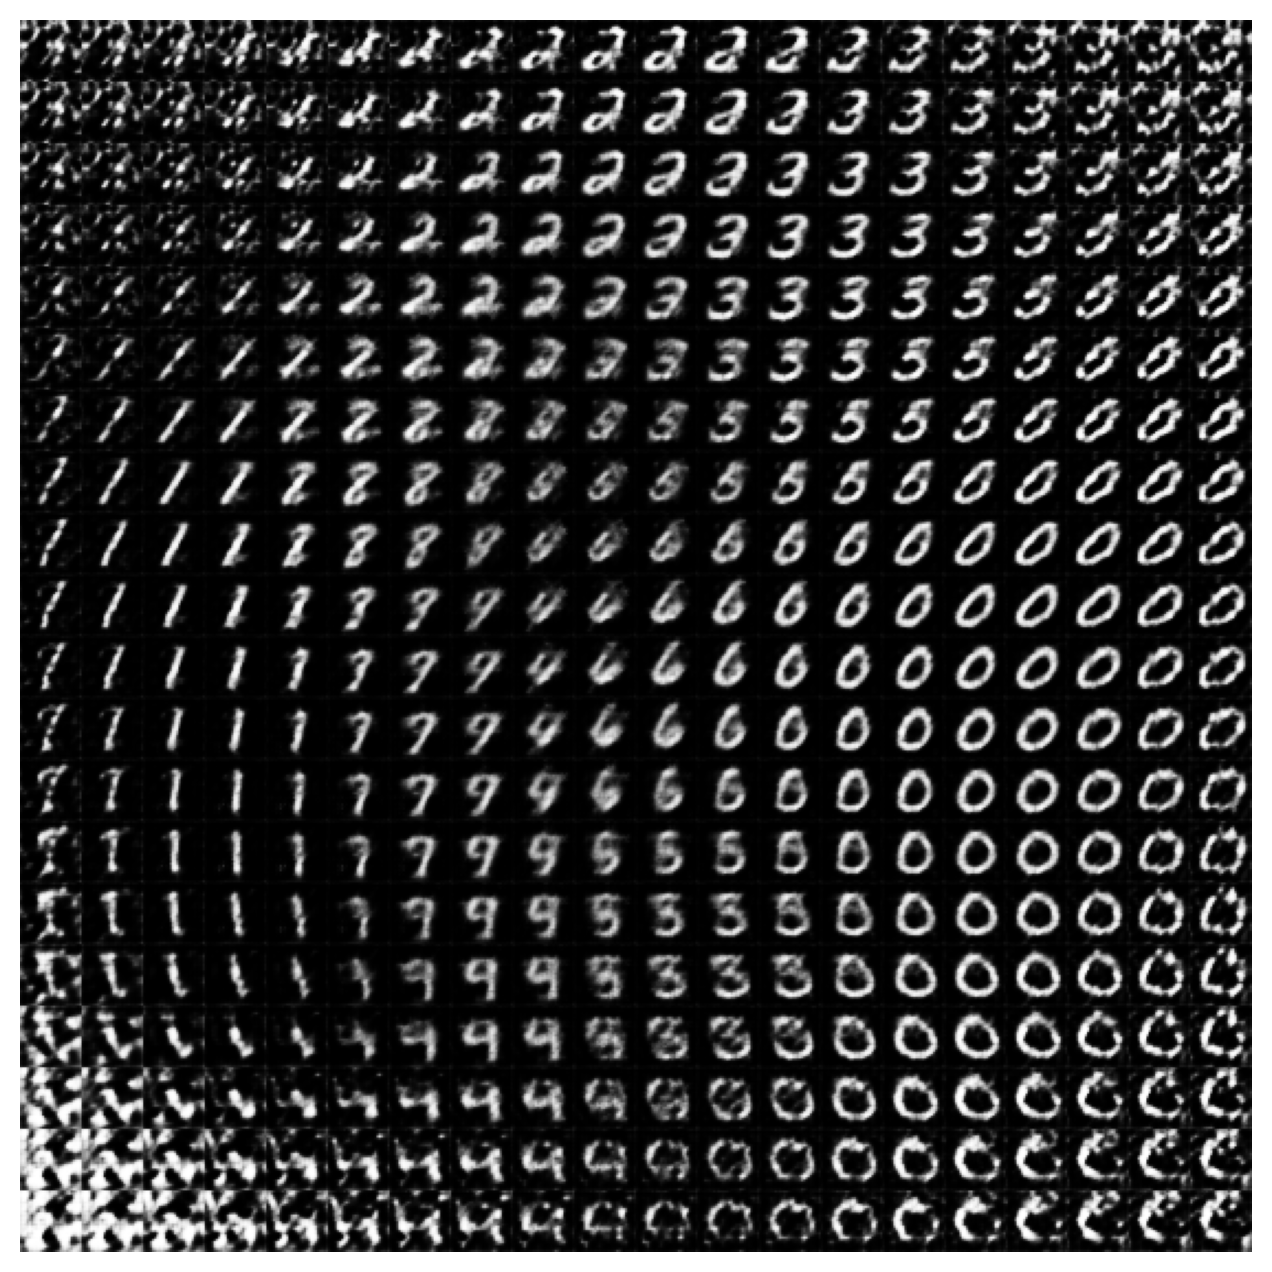

In [99]:
plot_latent_space_auto_lims(c_vaes[2][0.0])

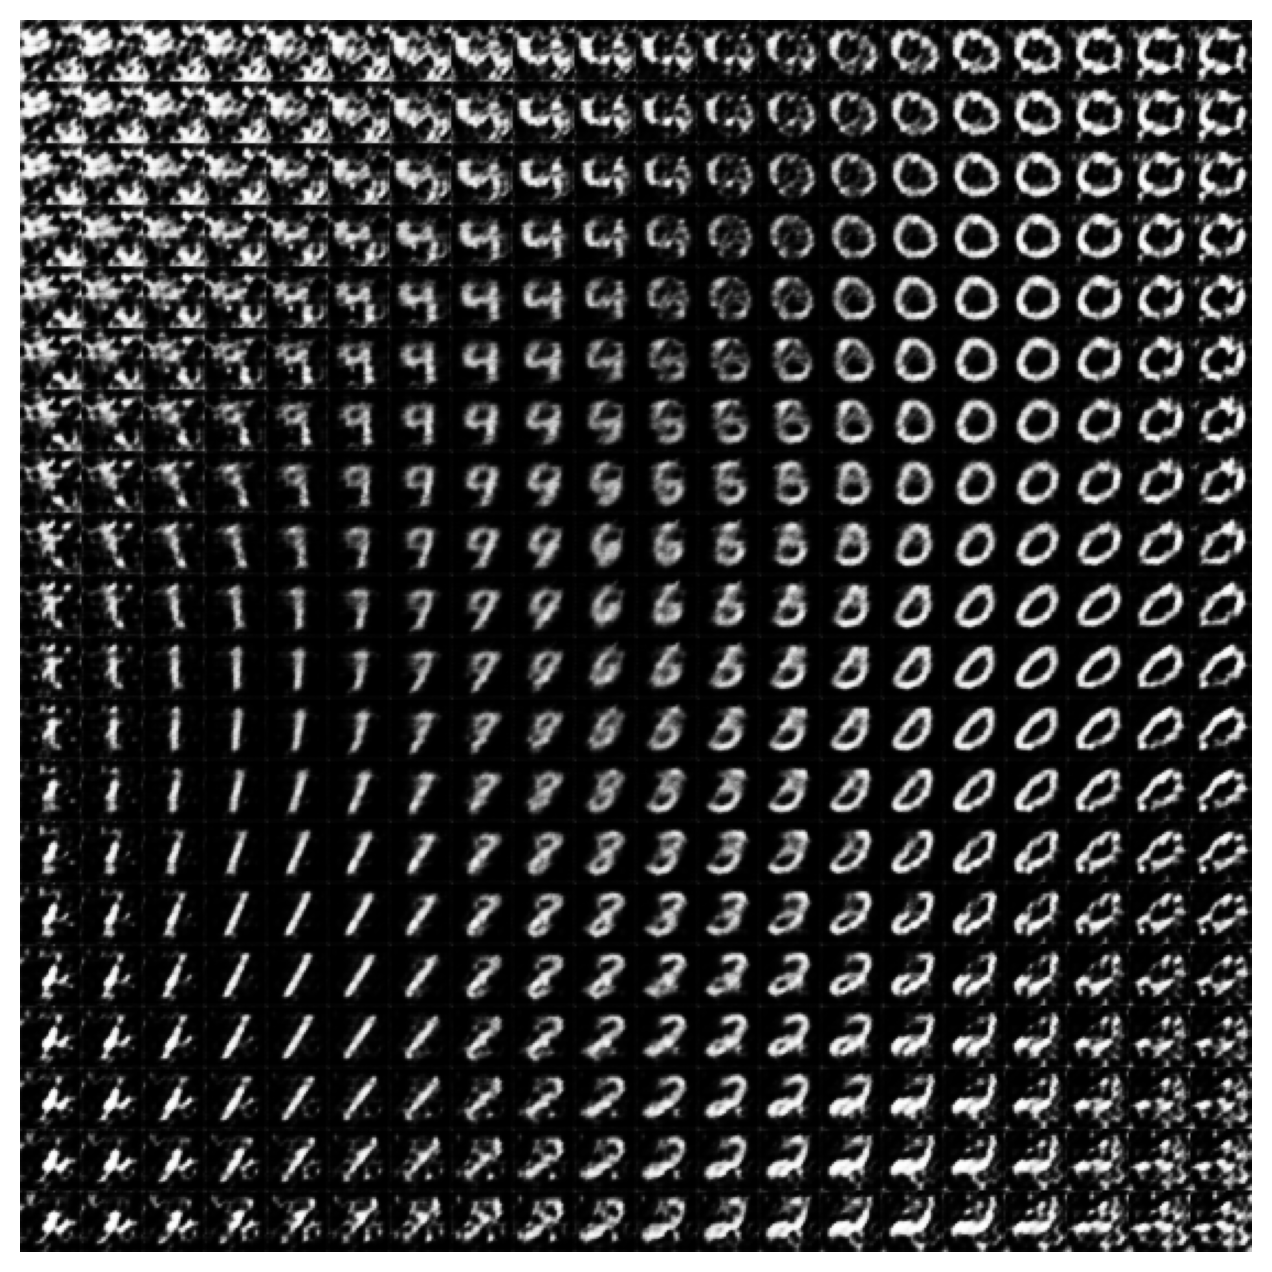

In [100]:
plot_latent_space_auto_lims(c_vaes[2][0.001])

In [107]:
distance_between_representation(c_vaes[2][0.0], all_0s[0], all_0s[1])

0.8384506702423096

In [108]:
distance_between_representation(c_vaes[2][0.001], all_0s[0], all_0s[1])

0.22767327725887299

In [109]:
distance_between_representation(c_vaes[2][1], all_0s[0], all_0s[1])

0.0021541789174079895

#### Distance between different digits

In [111]:
distance_between_representation(c_vaes[2][0.0], all_0s[0], all_1s[0])

11.220616340637207

In [113]:
distance_between_representation(c_vaes[2][0.001], all_0s[0], all_1s[0])

4.362278461456299

### Todo

1. Show Fashion MNIST results
2. Show tSNE plots
3. Create GIF of interpolation
4. Show on harder datasets (CIFAR, CelebA, etc.)
5. Show for varying number of Monte Carlo samples
6. Show from the Bayesian perspective
7. Show the performance of the model on the test set